### **Capstone Project: SkimLit**

In [1]:
# DL needs
import tensorflow as tf
import keras as kr

# Data needs
import pandas as pd
from sklearn.model_selection import train_test_split

# Numerical computation needs
import numpy as np

# plotting needs
import matplotlib.pyplot as plt
import matplotlib_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('svg')

# ensuring reproducibility
random_seed=42
tf.random.set_seed(random_seed)

import sys
sys.path.append('/home/rudraksha14/Desktop/RAY_RISE_ABOVE_YOURSELF/Programming/tensorflow/')

import important_functionalities as impf

2025-04-12 18:10:22.894449: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [13]:
baseline_results = {'accuracy': 72.1832384482987,
 'precision': 0.7186466952323352,
 'recall': 0.7218323844829869,
 'f1_score': 0.6989250353450294}

model_1_results = {'accuracy': 78.85939361842976,
 'precision': 0.7857351875581878,
 'recall': 0.7885939361842976,
 'f1_score': 0.7863604692957813}

model_2_results = {'accuracy': 71.4318813716404,
 'precision': 0.714442353759606,
 'recall': 0.714318813716404,
 'f1_score': 0.7113182138257264}

model_3_results = {'accuracy': 67.66847610221105,
 'precision': 0.688126153434333,
 'recall': 0.6766847610221104,
 'f1_score': 0.6649991504090976}

In [14]:
data_dir = 'pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/'

# check all of the filenames in the target directory
import os 
filenames = [data_dir + filename for filename in os.listdir(data_dir)]

In [15]:
def get_lines(filename):
    '''
    Reads file given a filename (text) and returns the lines of text as a list.
    '''
    with open(filename,'r') as file:
        return file.readlines()

In [16]:
def preprocess_text_with_line_number(filename):
    '''
    Takes in filename (str), reads its content and sorts through each line.
    Extracts things like the target label, the text of the sentence, how many sentences are in the current abstract and what sentence number the target line is.
    Returns a list of dictationaries of abstract line data.
    '''

    input_lines = get_lines(filename) # get all lines from file name
    abstract_lines = '' # create an empty abstract 
    abstract_samples = [] # create an empty list of abstracts

    # loop through each line in the target file
    for line in input_lines:
        if line.startswith('###'): # check to see if line is an ID line
            abstract_id = line
            abstract_lines = "" # reset the abstract string for every new abstract
            
        elif line.isspace(): # check to see if line is a newline
            abstract_lines_split = abstract_lines.splitlines() # split abstract into separate lines ('\n')

            # this is one particular abstract we are dealing with
            # iterate through each line in a single abstract, and count them at the same time.
            for abstract_line_no,abstract_line in enumerate(abstract_lines_split):
                line_data = {} # create an empty dictationary for each line
                target_text_split = abstract_line.split("\t")
                # text before \t is label, and after \t is text

                line_data['target'] = target_text_split[0] # get target label
                line_data['text'] = target_text_split[1].lower() # get target text and lowercase it
                line_data['line_number'] = abstract_line_no # what number line does the line appear in the abstract?
                line_data["total_lines"] = len(abstract_lines_split) - 1 # how many total lines are there in the target abstract ? (start from 0)
                
                # add line data to abstract samples list
                abstract_samples.append(line_data)

        else: # if the above conditions are not fulfilled, the line contains a labelled sentence
            abstract_lines += line
    
    return abstract_samples

In [17]:
%%time
# get data from file and pre-process it

train_samples = preprocess_text_with_line_number(data_dir+'train.txt')
val_samples = preprocess_text_with_line_number(data_dir+'dev.txt')
test_samples = preprocess_text_with_line_number(data_dir+'test.txt')
len(train_samples),len(val_samples),len(test_samples)

CPU times: user 418 ms, sys: 118 ms, total: 536 ms
Wall time: 535 ms


(180040, 30212, 30135)

In [18]:
# # turning data into dataframe to further visualize
train_df = pd.DataFrame(train_samples)
val_df = pd.DataFrame(val_samples)
test_df = pd.DataFrame(test_samples)

In [19]:
train_sentences = train_df['text'].to_list()
val_sentences = val_df['text'].to_list()
test_sentences = test_df['text'].to_list()
len(train_sentences),len(val_sentences),len(test_sentences)

(180040, 30212, 30135)

In [20]:
# NUMERIC_LABELLING
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()

train_labels_encoded = label_encoder.fit_transform(train_df['target'].to_numpy())
val_labels_encoded = label_encoder.fit_transform(val_df['target'].to_numpy())
test_labels_encoded = label_encoder.fit_transform(test_df['target'].to_numpy())

train_labels_encoded

array([3, 2, 2, ..., 4, 1, 1])

In [21]:
# ONE_HOT_ENCODING
from sklearn.preprocessing import OneHotEncoder

one_hot_encoder = OneHotEncoder(sparse_output=False) # we want non-sparse matrix

train_labels_one_hot = one_hot_encoder.fit_transform(train_df['target'].to_numpy().reshape(-1,1))
val_labels_one_hot = one_hot_encoder.fit_transform(val_df['target'].to_numpy().reshape(-1,1))
test_labels_one_hot = one_hot_encoder.fit_transform(test_df['target'].to_numpy().reshape(-1,1))

train_labels_one_hot

array([[0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       ...,
       [0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.]])

In [22]:
# Get the class names and number of classes from LabelEncoder instance
num_classes = len(label_encoder.classes_)
class_names = label_encoder.classes_
# print(class_names,num_classes)

**character-embedding**

In [23]:
# make function to split sentence into characters
def split_chars(text):
    return " ".join(list(text))

split_chars("The quick brown fox jumped over the lazy dog")

'T h e   q u i c k   b r o w n   f o x   j u m p e d   o v e r   t h e   l a z y   d o g'

In [24]:
# split sequence-level data splits into character-level data splits
train_chars = [split_chars(sentence) for sentence in train_sentences]
val_chars = [split_chars(sentence) for sentence in val_sentences]
test_chars = [split_chars(sentence) for sentence in test_sentences]
train_chars[:5]

['t o   i n v e s t i g a t e   t h e   e f f i c a c y   o f   @   w e e k s   o f   d a i l y   l o w - d o s e   o r a l   p r e d n i s o l o n e   i n   i m p r o v i n g   p a i n   ,   m o b i l i t y   ,   a n d   s y s t e m i c   l o w - g r a d e   i n f l a m m a t i o n   i n   t h e   s h o r t   t e r m   a n d   w h e t h e r   t h e   e f f e c t   w o u l d   b e   s u s t a i n e d   a t   @   w e e k s   i n   o l d e r   a d u l t s   w i t h   m o d e r a t e   t o   s e v e r e   k n e e   o s t e o a r t h r i t i s   (   o a   )   .',
 'a   t o t a l   o f   @   p a t i e n t s   w i t h   p r i m a r y   k n e e   o a   w e r e   r a n d o m i z e d   @ : @   ;   @   r e c e i v e d   @   m g / d a y   o f   p r e d n i s o l o n e   a n d   @   r e c e i v e d   p l a c e b o   f o r   @   w e e k s   .',
 'o u t c o m e   m e a s u r e s   i n c l u d e d   p a i n   r e d u c t i o n   a n d   i m p r o v e m e n t   i n   f u n c t i o n   s c o r e s   a 

In [25]:
# finding the average character length
char_lens = [len(sentence) for sentence in train_sentences]
avg_char_len = tf.reduce_mean(char_lens)
avg_char_len

<tf.Tensor: shape=(), dtype=int32, numpy=149>

In [28]:
# finding what length of characters covers 95% of our dataset
output_char_seq_len = int(np.percentile(char_lens,95))
output_char_seq_len

290

In [29]:
# max char-tokens (total number of unique characters available)
import string
alphabet = string.ascii_lowercase + string.digits + string.punctuation
print(alphabet)


# the length of this covers all basis for our characters
MAX_CHAR_TOKENS = len(alphabet) + 2 # alphabet doesn't include space & OOV (OUT OF VOCAB '[UNK]') token
print(MAX_CHAR_TOKENS)

# Vocabulary size (refer paper: for PUBMED-20k it is 68k)
MAX_TOKENS  = 68000

abcdefghijklmnopqrstuvwxyz0123456789!"#$%&'()*+,-./:;<=>?@[\]^_`{|}~
70


In [30]:
# creating the text-vectorizer (char-level) layer
text_char_vectorizer = tf.keras.layers.TextVectorization(max_tokens = MAX_CHAR_TOKENS, # no of unique chars
                                                    output_sequence_length = output_char_seq_len, # desired output length of vectorized sequences
                                                    # all other params kept default,
                                                    name = 'text_char_vectorizer',
                                                    # standardize = None
                                                    standardize = 'lower_and_strip_punctuation'
                                                    )
# we will keep the `default standardization on`
# we set `standardize to None` if we want punctuation to be preserved

In [31]:
# adapt the text char vectorizer (char level) to train chars
text_char_vectorizer.adapt(train_chars)

2025-04-12 18:18:05.866774: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 504080352 exceeds 10% of free system memory.


In [36]:
character_embedding = tf.keras.layers.Embedding(input_dim = MAX_CHAR_TOKENS, # number of different chars
                                           output_dim = 25, # refer paper - fig.1
                                           mask_zero = True,
                                           name = 'char_embed'
                                           )

In [33]:
import tensorflow_hub as hub
@kr.saving.register_keras_serializable(package="my_custom_package")
class UniversalEncodedLayer(tf.keras.layers.Layer):
    def __init__(self,**kwargs):
        super().__init__(**kwargs)
        self.use_layer = hub.KerasLayer("https://www.kaggle.com/models/google/universal-sentence-encoder/TensorFlow2/universal-sentence-encoder/2",
                                        input_shape = [],
                                        dtype=tf.string,
                                        trainable=False, # default=False,
                                        name='USE'
                                        )

    def call(self,inputs):
        return self.use_layer(inputs)


**11. Model 4: Multi-modal input model with Pretrained token embeddings (same as 2) + character embedding (same as 3)**

1. Create a token - level embedding (similar to `model 2`)
2. Create a character level model (similar to `model 3` with a slight modification)
3. Combine (1) and (2) with a concatenate layer (`tf.keras.layers.Concatenate`)
4. Build a series of output layers on top of (3) similar to fig.1 in section 4.2 in paper
5. Construct a model which takes token and character-level sequences as inputs and produces sequence label probabilities as output


* Paper uses a dimension of 300 as output of token embedding, we will use 128 (multiple of 8), and since we are also using USE which is quite advanced compared to GloVe embeddings.
* Paper uses 50 LSTM units (Bi-LSTM: 25*2), here we shall use a multiple of 8
* `NotEqual` is added automatically because during vectorization, the layer checks whether each input token is empty or not.

In [40]:
# 1. setup token-level embedding model
token_inputs = tf.keras.layers.Input(shape = [], dtype=tf.string, name = 'token_input')
token_embeddings = UniversalEncodedLayer()(token_inputs)
token_outputs = tf.keras.layers.Dense(128,activation='relu')(token_embeddings)
token_model = tf.keras.models.Model(inputs=token_inputs,outputs=token_outputs)

# 2. setup character-level embedding model
char_inputs = tf.keras.layers.Input(shape = (1,),dtype = tf.string, name = 'char_input')
char_vectorizations = text_char_vectorizer(char_inputs)
char_embeddings = character_embedding(char_vectorizations)
char_bi_lstm = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(24))(char_embeddings) # Bi-LSTM used in paper
char_model = tf.keras.models.Model(inputs = char_inputs, outputs = char_bi_lstm)

# 3. combine outputs of both models (Concatenate token and char inputs: Create hybrid token embedding)
token_char_concat = tf.keras.layers.Concatenate(name = 'token_char_hybrid')([token_model.output,
                                                                             char_model.output])

# 4. Create the output layer (also add in drop-out of 0.5)
### drop-out applied to combined token-char hybrid output
combined_dropout = tf.keras.layers.Dropout(0.5)(token_char_concat)

combined_dense = tf.keras.layers.Dense(units = 128, activation='relu')(combined_dropout)

### drop-out applied before output layer
final_dropout = tf.keras.layers.Dropout(0.5)(combined_dense)

output_layer = tf.keras.layers.Dense(units = num_classes, activation='softmax')(final_dropout)

# 5. Contruct model with char and token inputs 
model_4 = tf.keras.models.Model(inputs = [token_model.input,char_model.input],
                                outputs = output_layer,
                                name = 'model_4' 
                                )
model_4.summary()

Model: "model_4"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ char_input          │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ token_input         │ (None)            │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ text_char_vectoriz… │ (None, 290)       │          0 │ char_input[0][0]  │
│ (TextVectorization) │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ universal_encoded_… │ (None, 512)       │          0 │ token_input[0][0] │
│ (UniversalEncodedL… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ char_embed          │ (None, 290, 25)   │      1,750 │ text_char_vector… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ not_equal_2         │ (None, 290)       │          0 │ text_char_vector… │
│ (NotEqual)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_6 (Dense)     │ (None, 128)       │     65,664 │ universal_encode… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_2     │ (None, 48)        │      9,600 │ char_embed[2][0], │
│ (Bidirectional)     │                   │            │ not_equal_2[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ token_char_hybrid   │ (None, 176)       │          0 │ dense_6[0][0],    │
│ (Concatenate)       │                   │            │ bidirectional_2[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_4 (Dropout) │ (None, 176)       │          0 │ token_char_hybri… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_7 (Dense)     │ (None, 128)       │     22,656 │ dropout_4[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_5 (Dropout) │ (None, 128)       │          0 │ dense_7[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_8 (Dense)     │ (None, 5)         │        645 │ dropout_5[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 100,315 (391.86 KB)

 Trainable params: 100,315 (391.86 KB)

 Non-trainable params: 0 (0.00 B)

In [43]:
plot_model?

Signature:
plot_model(
    model,
    to_file='model.png',
    show_shapes=False,
    show_dtype=False,
    show_layer_names=False,
    rankdir='TB',
    expand_nested=False,
    dpi=200,
    show_layer_activations=False,
    show_trainable=False,
    **kwargs,
)
Docstring:
Converts a Keras model to dot format and save to a file.

Example:

```python
inputs = ...
outputs = ...
model = keras.Model(inputs=inputs, outputs=outputs)

dot_img_file = '/tmp/model_1.png'
keras.utils.plot_model(model, to_file=dot_img_file, show_shapes=True)
```

Args:
    model: A Keras model instance
    to_file: File name of the plot image.
    show_shapes: whether to display shape information.
    show_dtype: whether to display layer dtypes.
    show_layer_names: whether to display layer names.
    rankdir: `rankdir` argument passed to PyDot,
        a string specifying the format of the plot: `"TB"`
        creates a vertical plot; `"LR"` creates a horizontal plot.
    expand_nested: whether to expand nested

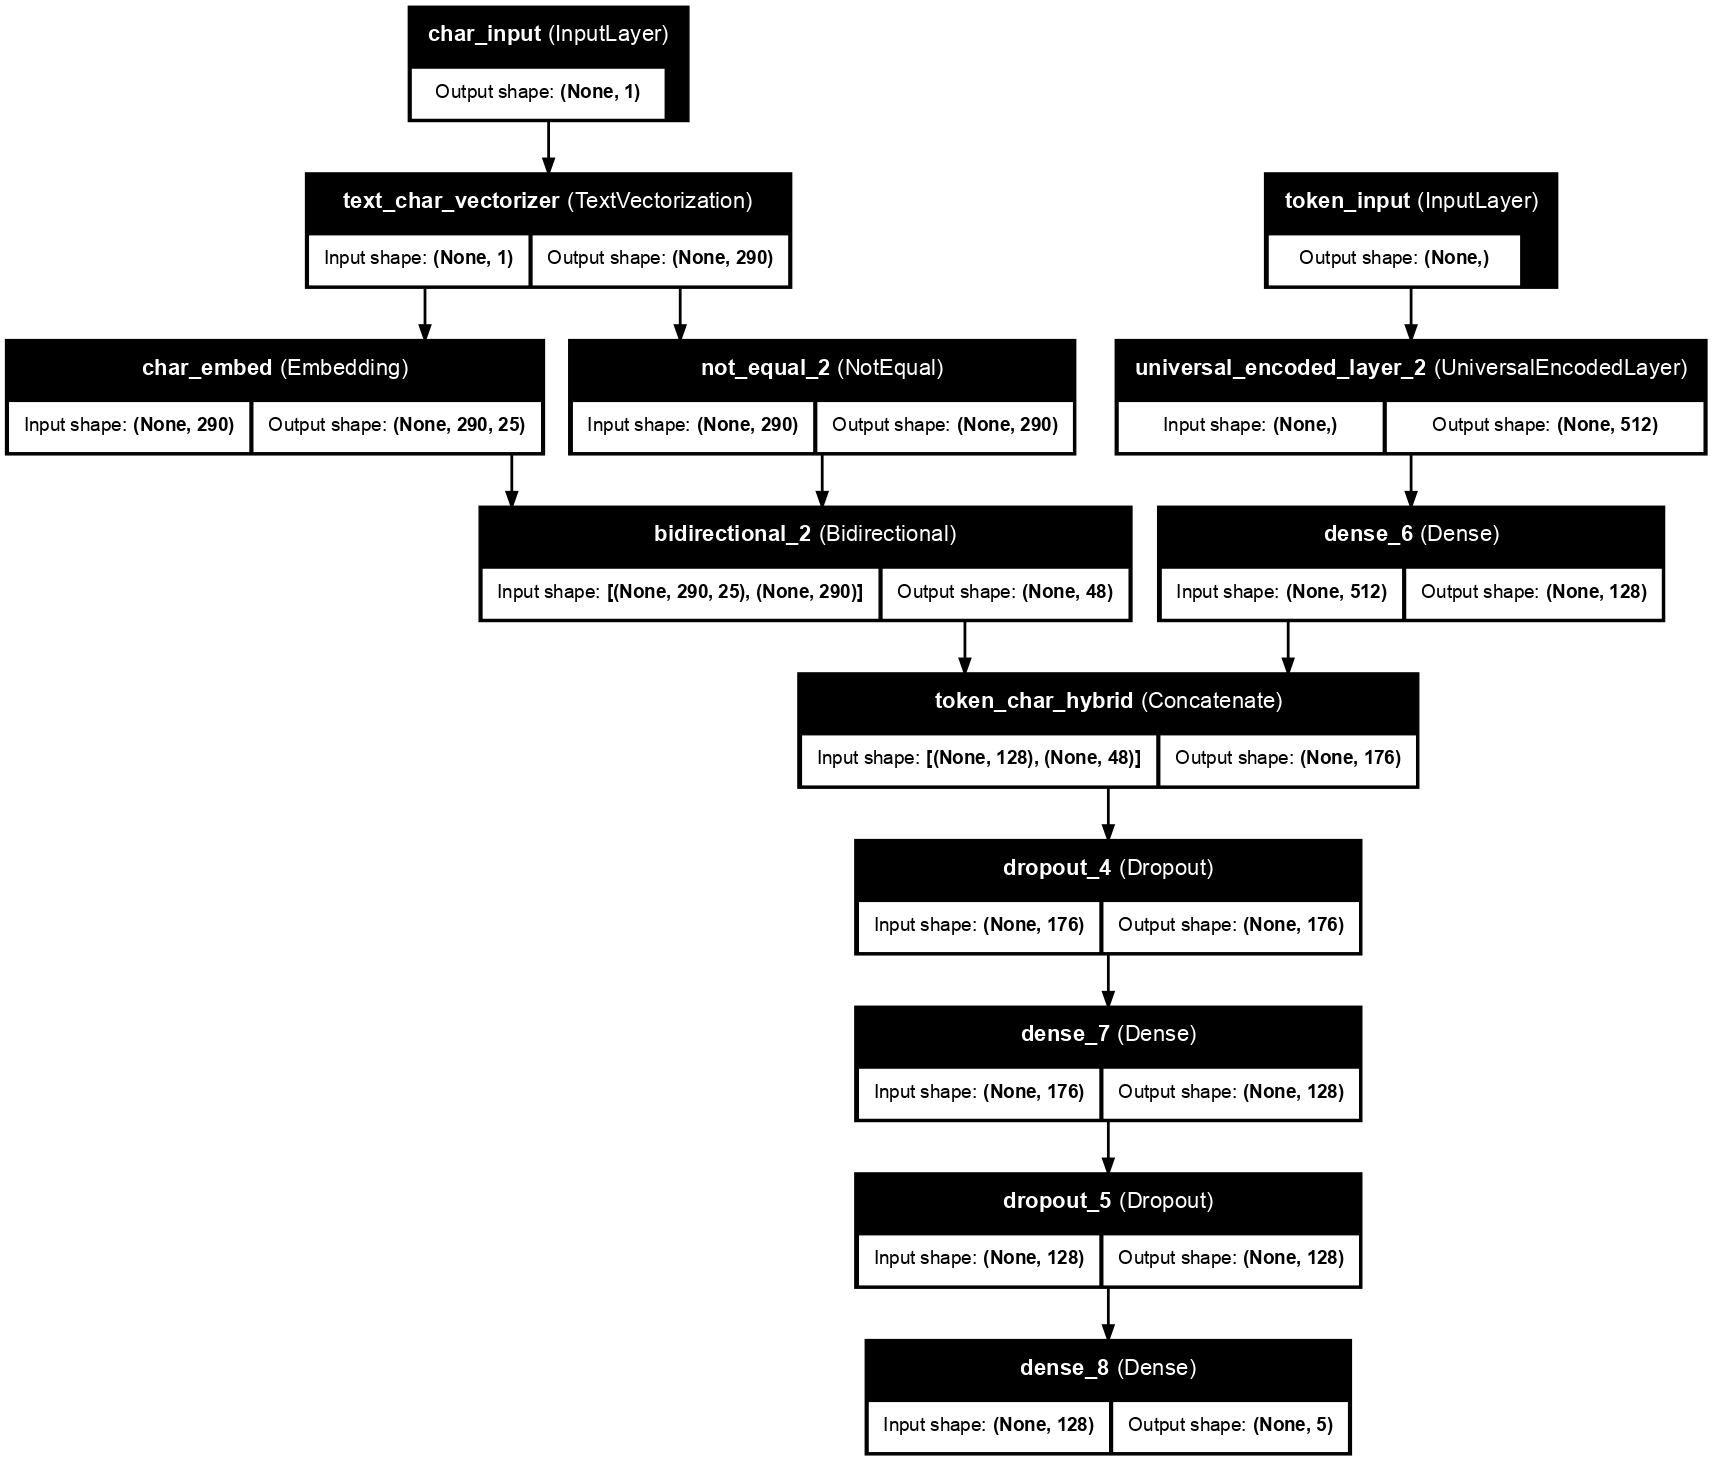

In [53]:
# plotting the model 
from keras.utils import plot_model

plot_model(model_4,
            expand_nested=True,
            dpi=100,show_layer_names=True,show_shapes = True)

In [54]:
# compile the model
model_4.compile(loss = 'categorical_crossentropy', optimizer = tf.keras.optimizers.Adam(), metrics = ['accuracy'])

**12. Preparing dataset for multimodal data**

In [ ]:
train_char_token_data = tf.data.Dataset.from_tensor_slices((train_sentences,train_chars))
train_char_token_labels = tf.data.Dataset.from_tensor_slices(train_labels_one_hot)
train_dataset = tf.data.Dataset.zip((train_char_token_data,train_char_token_labels))
# order is important - (token , char) 

val_char_token_data = tf.data.Dataset.from_tensor_slices((val_sentences,val_chars))
val_char_token_labels = tf.data.Dataset.from_tensor_slices(val_labels_one_hot)
val_dataset = tf.data.Dataset.zip((val_char_token_data,val_char_token_labels))

test_char_token_data = tf.data.Dataset.from_tensor_slices((test_sentences,test_chars))
test_char_token_labels = tf.data.Dataset.from_tensor_slices(test_labels_one_hot)
test_dataset = tf.data.Dataset.zip((test_char_token_data,test_char_token_labels))


BATCH_SIZE = 32
# PREFETCHING AND BATCHING
train_dataset = train_dataset.batch(batch_size=BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
val_dataset = val_dataset.batch(batch_size=BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(batch_size=BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

In [57]:
# fitting the model
hist_model_4 = model_4.fit(train_dataset,
            steps_per_epoch = int(0.1*len(train_dataset)),
            epochs = 3,
            validation_data = val_dataset,
            validation_steps = int(0.1*len(val_dataset))
            )

Epoch 1/3
562/562 ━━━━━━━━━━━━━━━━━━━━ 59s 96ms/step - accuracy: 0.5228 - loss: 1.1658 - val_accuracy: 0.6925 - val_loss: 0.7935
Epoch 2/3
562/562 ━━━━━━━━━━━━━━━━━━━━ 48s 84ms/step - accuracy: 0.6895 - loss: 0.8096 - val_accuracy: 0.7231 - val_loss: 0.7224
Epoch 3/3
562/562 ━━━━━━━━━━━━━━━━━━━━ 48s 85ms/step - accuracy: 0.6966 - loss: 0.7809 - val_accuracy: 0.7387 - val_loss: 0.6963


In [58]:
# evaluate model 1
model_4.evaluate(val_dataset)

945/945 ━━━━━━━━━━━━━━━━━━━━ 20s 21ms/step - accuracy: 0.7333 - loss: 0.7005


[0.7014781832695007, 0.7332847714424133]

In [59]:
# make predictions using model 1
model_4_pred_probs = model_4.predict(val_dataset)
model_4_pred_probs,model_4_pred_probs.shape

945/945 ━━━━━━━━━━━━━━━━━━━━ 21s 21ms/step


(array([[3.9432925e-01, 3.7901810e-01, 6.2787128e-03, 2.1164165e-01,
         8.7322202e-03],
        [3.1028682e-01, 5.1500195e-01, 3.7346147e-03, 1.6939227e-01,
         1.5844164e-03],
        [2.6698169e-01, 8.7968156e-02, 4.1652627e-02, 5.7459140e-01,
         2.8806100e-02],
        ...,
        [6.5986859e-04, 1.0082504e-02, 5.3767558e-02, 2.8697753e-04,
         9.3520308e-01],
        [8.8759791e-03, 6.0560070e-02, 2.2248162e-01, 3.6372896e-03,
         7.0444500e-01],
        [2.8905517e-01, 3.8862729e-01, 2.4192955e-01, 3.0659920e-02,
         4.9728069e-02]], dtype=float32),
 (30212, 5))

In [60]:
# convert pred-probs to classes

pred_labels = tf.argmax(model_4_pred_probs,axis=1)
pred_classes  = [class_names[label] for label in pred_labels]
pred_labels,pred_classes

(<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 1, 3, ..., 4, 4, 1])>,
 ['BACKGROUND',
  'CONCLUSIONS',
  'OBJECTIVE',
  'METHODS',
  'METHODS',
  'METHODS',
  'RESULTS',
  'RESULTS',
  'RESULTS',
  'CONCLUSIONS',
  'OBJECTIVE',
  'CONCLUSIONS',
  'CONCLUSIONS',
  'OBJECTIVE',
  'METHODS',
  'METHODS',
  'OBJECTIVE',
  'CONCLUSIONS',
  'CONCLUSIONS',
  'CONCLUSIONS',
  'OBJECTIVE',
  'BACKGROUND',
  'BACKGROUND',
  'CONCLUSIONS',
  'METHODS',
  'BACKGROUND',
  'METHODS',
  'METHODS',
  'METHODS',
  'METHODS',
  'RESULTS',
  'CONCLUSIONS',
  'CONCLUSIONS',
  'CONCLUSIONS',
  'CONCLUSIONS',
  'RESULTS',
  'METHODS',
  'RESULTS',
  'RESULTS',
  'RESULTS',
  'CONCLUSIONS',
  'CONCLUSIONS',
  'CONCLUSIONS',
  'CONCLUSIONS',
  'CONCLUSIONS',
  'OBJECTIVE',
  'METHODS',
  'METHODS',
  'RESULTS',
  'RESULTS',
  'METHODS',
  'RESULTS',
  'RESULTS',
  'METHODS',
  'RESULTS',
  'OBJECTIVE',
  'RESULTS',
  'CONCLUSIONS',
  'BACKGROUND',
  'BACKGROUND',
  'OBJECTIVE',
  'RESULTS',
  'METH

In [61]:
model_4_results = impf.calculate_results(val_labels_encoded,pred_labels)
model_4_results

{'accuracy': 73.32847875016549,
 'precision': 0.7343242936679377,
 'recall': 0.7332847875016549,
 'f1_score': 0.7302327895319348}

***-- CONTD IN NEXT NOTEBOOK --***